# Graph country accuracy vs. blast

In [1]:
import numpy as np
import pandas as pd
import sys
import random
import os
random.seed(42)
np.random.seed(42)
sys.path.append("../")
from common.plot_style_utils import set_pub_plot_context, save_for_pub
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
result_name = '../../data/blast/blast_country_test.csv'
predictions_name = 'country_blast_test_predictions'

In [3]:
database = "countries"

#evalue cutoff 
cutoff = 10
x = pd.read_pickle("../../data/tts/x_test_country.pkl")
y = pd.read_pickle("../../data/tts/y_test_country.pkl")
full_y = y

In [4]:
if database == "firstorder":
    train_y = pd.read_pickle("../../data/tts/y_train_ord.pkl")
elif database == "countries":
    train_y = pd.read_pickle("../../data/tts/y_train_country.pkl")
else:
    raise ValueError("Database unknown")

# The below requires a lot of memory (>32 G) to run.
If does not run, the result value has been hardcoded below, skip there.

In [5]:
predictions = []
k = 10
headers = ['query_id', 'subject_id', 'identity', 'alignment length', 'mismatches', 'gap opens', 'q. start', 'q. end', 's. start', 's. end', 'evalue', 'bit score']
result = pd.read_csv(result_name, index_col=1, sep='\t', names=headers).reset_index()
print(result.head())
# for every element in query
for i in range(len(x)):
    queryi_result = result[result["query_id"] == i]
    # sort all the hits by evalue, drop duplicate hits (keeping the lowest evalue)
    sorted_hits = np.asarray(
        queryi_result.sort_values("evalue").loc[:,"subject_id"].drop_duplicates().values, 
        dtype=int
    )
    # Look up the train set labels for each sequence hit, drop the duplicate labs
    # (keeping the evalue ordering) and take the first k lab predictions
    predictions.append(pd.Series(train_y[sorted_hits]).drop_duplicates().values[:k])

/home/sandias42/miniconda3/envs/attrib/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


   subject_id  query_id  identity  alignment length  mismatches  gap opens  \
0           0         0     92.28               622          36         12   
1       19632         0     92.13               597          35         12   
2           9         0     92.13               597          35         12   
3       32711         0     92.07               593          35         12   
4        1151         0     85.31               572          75          9   

   q. start  q. end  s. start  s. end         evalue  bit score  
0       581    1198      3816    3203   0.000000e+00      872.0  
1       606    1198      3343    2755   0.000000e+00      832.0  
2       606    1198      3401    2813   0.000000e+00      832.0  
3       610    1198      3985    3401   0.000000e+00      824.0  
4       609    1177      3330    2765  1.000000e-164      582.0  


In [6]:
%xdel result

In [7]:
predictions[:10]

[array([33.,  0.,  9.]),
 array([33., 18.,  5.]),
 array([], dtype=float64),
 array([], dtype=float64),
 array([33., 32., 30.,  9.,  5., 10., 20.,  7., 28., 21.]),
 array([33.,  3.]),
 array([32., 33.]),
 array([33., 31., 28., 19., 26., 30., 18.,  7.,  3., 32.]),
 array([], dtype=float64),
 array([33., 10., 32., 22., 30., 20.,  0.,  9.])]

In [8]:
y[:10]

array([33., 33., 33., 33., 33., 33., 33., 33., 33., 33.])

In [9]:
np.save(predictions_name,np.array(predictions, dtype=object))

In [10]:
full_predictions = np.array(predictions, dtype=object)


In [11]:
# first do the no united states accuracy
mask = ~(y == 33) # Not the United States
predictions = full_predictions[mask]
y = full_y[mask]

In [12]:
# Top 1 accuracy = .7028
top1_prediction = np.array([a[0] if len(a) != 0 else 9999999 for a in predictions])
correct = (top1_prediction == y)
blast_accuracy1 = np.mean(correct)
blast_accuracy1

0.7028717657094115

In [13]:
# topk accuracy (see k set above)
# k=10, top10acc = .8672
correct = [y[i] in predictions[i] if len(predictions[i]) != 0 else y[i] == 9999999 for i in range(len(y))]
blast_accuracy10 = np.mean(correct)
blast_accuracy10

0.8672163775945408

In [14]:
# now do US vs not accuracy
predictions = full_predictions
y = full_y == 33 # True if y is United States else false

In [15]:
# US vs. not accuracy = .8515

top1_prediction = np.array([a[0] if len(a) != 0 else 9999999 for a in predictions])
top1_prediction = top1_prediction == 33
correct = (top1_prediction == y)
blast_accuracy1 = np.mean(correct)
blast_accuracy1


0.8515520853170825

# Skip here on low-ram machine.

In [5]:
true = pd.read_pickle("../../data/tts/y_test_country.pkl")

guessing = np.sum(true == 33) / len(true)
guessing

0.6651114073509807

In [6]:
# Now US vs not, precomputed values from fig a_c notebook
labels = ["Blast", "RF", "Baseline", "Uniform"]
acc = [.8515,.842,guessing, .5]

In [7]:
import warnings
warnings.filterwarnings('once')

/home/sandias42/miniconda3/envs/attrib/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


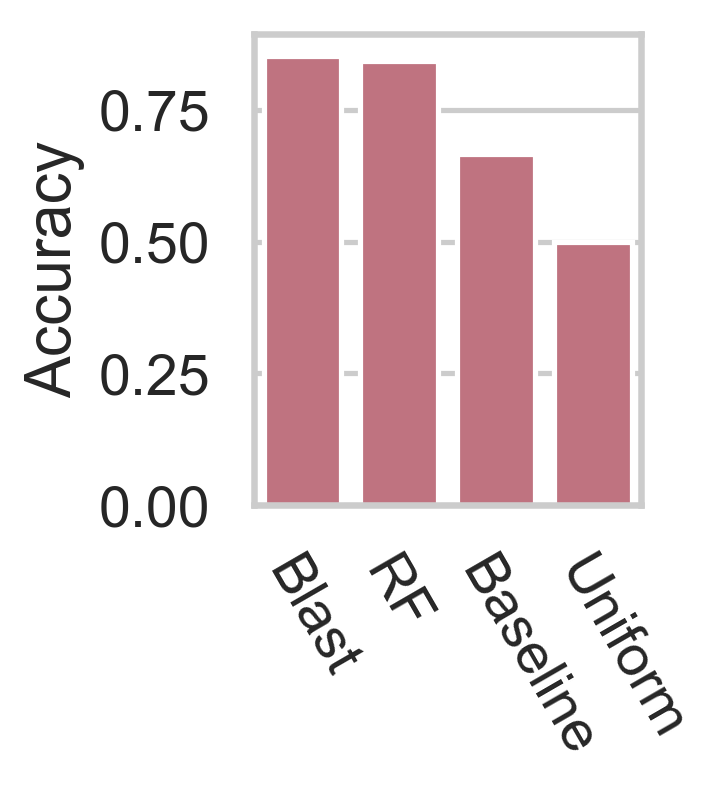

In [8]:
set_pub_plot_context(context="talk")
fig = plt.figure(figsize=(2,2.5), dpi=250)
ax1 = fig.add_subplot(111,
                    ylabel="Accuracy")
palette = sns.color_palette()

sns.barplot(y=acc, x=labels, alpha=1, ax=ax1, color=palette[1])
plt.xticks(rotation=-60, ha="left", rotation_mode="anchor")
plt.legend(loc='lower right', framealpha=1)
!mkdir ../../data/manuscript/figs/3/a
save_for_pub(fig, path="../../data/manuscript/figs/3/a/v0", dpi=500)

In [9]:
# Now nation-of-origin. Precomputed values from fig_3_d notebook called
# `Fig3de_map_nous_accuracy_and_training_set_size_effects` with blast
# from above
print(len(np.unique(y)))
labels = ["RF", "Blast", "Baseline", "Uniform"]
top1 = [.758,.702,.161,1/len(np.unique(full_y))]
top10 = [.967,.8672, .838, (1/len(np.unique(full_y))) * 10]
df = pd.DataFrame({'Method':labels + labels, "Accuracy":top1 + top10, 
                   "Top k":["k=1"] * 4 + ["k=10"]*4})
df

33


,Method,Accuracy,Top k
0,RF,0.758000,k=1
1,Blast,0.702000,k=1
2,Baseline,0.161000,k=1
3,Uniform,0.030303,k=1
4,RF,0.967000,k=10
5,Blast,0.867200,k=10
6,Baseline,0.838000,k=10
7,Uniform,0.303030,k=10


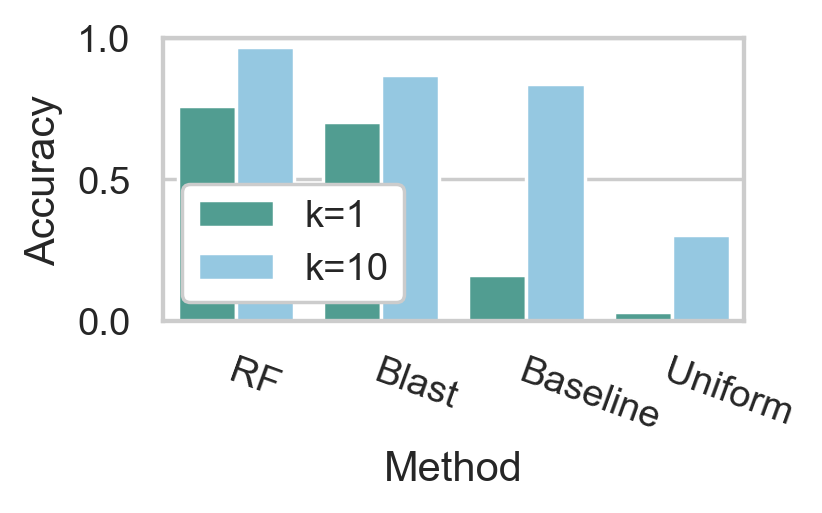

In [10]:
set_pub_plot_context(context="notebook")
fig = plt.figure(figsize=(3,1.5), dpi=250)
ax1 = fig.add_subplot(111,
                    xlabel="Accuracy")
palette = sns.color_palette()
sns.set_palette([palette[6]] + [palette[0]])

sns.barplot(y="Accuracy", x="Method", hue="Top k", data=df, alpha=1, ax=ax1 )
ax1.set_ylim(0,1)
plt.xticks(rotation=-20, ha="left", rotation_mode="anchor")
plt.legend(loc='lower left', framealpha=1)
!mkdir ../../data/manuscript/figs/3/c
save_for_pub(fig, path="../../data/manuscript/figs/3/c/v0", dpi=500)